  **The objective of this predictive analysis is to utilize machine learning algorithms to forecast the sales of individual products. This enables the company to tailor offers accordingly to each product based on various attributes provided in the dataset.**

  **The supermarket_sales dataset comprises information about sales, including unit price, product, cogs, and gross income.**

  **Attribute Information**


*   **Invoice ID**: Computer generated sales slip invoice identification number
*   **Branch**: Branch of supercenter (3 branches are available identified by A, B, and C).
*   **City**: Location of supercenters
*   **Customer** **type**: Type of customers, recorded by Members for customers using member card and Normal for without member card
*   **Gender**: Gender type of customer
*   **Product** **line**: General item categorization groups
*   **Unit price**: Price of each product in $
*   **Quantity**: Number of products purchased by the customer
*   **Tax 5%**: 5% tax fee for customer buying
*   **Total**: Total price including tax
*   **Date**: Date of purchase
*   **Time**: Purchase time
*   **Payment**: Payment used by the customer for their purchase
*   **cogs**: Cost of goods sold
*   **gross margin percentage**: financial metric
*   **gross income**: total revenue
*   **Rating**: Customer stratification rating on their overall shopping experience (On a scale of 1 to 10)







**Import Libraries**

Let's import some libraries to get started!

In [4]:
# dependencies

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_palette(sns.color_palette(['#851836', '#edbd17']))
sns.set_style("darkgrid")

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

**Reading the dataset**


In [5]:
df = pd.read_csv('/content/supermarket_sales - Sheet1.csv')
df.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


**Numeric Aggregation**

Below, we group by Branch and perform three statistical aggregations (**mean**, **standard** **deviation**, and **count**) by transforming the numeric columns of interest. For example, in the first column assignment, we calculate the mean Tax 5% and mean Unit price for every branch, which gives us two new columns - tax_branch_mean and unit_price_mean in the data frame.

In [6]:
# Numeric aggregations

grouped_df = df.groupby('Branch')

df[['tax_branch_mean','unit_price_mean']] = grouped_df[['Tax 5%', 'Unit price']].transform('mean')

df[['tax_branch_std','unit_price_std']] = grouped_df[['Tax 5%', 'Unit price']].transform('std')

df[['product_count','gender_count']] = grouped_df[['Product line', 'Gender']].transform('count')

And we see the features we've just created below.

In [7]:
df[['Branch', 'tax_branch_mean', 'unit_price_mean', 'tax_branch_std',
    'unit_price_std', 'product_count', 'gender_count']].head(10)

,Branch,tax_branch_mean,unit_price_mean,tax_branch_std,unit_price_std,product_count,gender_count
0,A,14.874001,54.780853,11.030477,26.132127,340,340
1,C,16.052367,56.609024,12.531470,27.179799,328,328
2,A,14.874001,54.780853,11.030477,26.132127,340,340
3,A,14.874001,54.780853,11.030477,26.132127,340,340
4,A,14.874001,54.780853,11.030477,26.132127,340,340
5,C,16.052367,56.609024,12.531470,27.179799,328,328
6,A,14.874001,54.780853,11.030477,26.132127,340,340
7,C,16.052367,56.609024,12.531470,27.179799,328,328
8,A,14.874001,54.780853,11.030477,26.132127,340,340
9,B,15.232024,55.659277,11.545122,26.224559,332,332


**Note**: since we're viewing a column subset of the full df, it looks like there are duplicate rows. When the rest of the columns are visible you'll notice there aren't duplicate rows, but there are still duplicate values. This is by design.

Below we can see a couple of the columns we created (tax_branch_mean and unit_price_mean). They are aggregations based on the Branch variable.

In [8]:
df[['Tax 5%', 'Unit price', 'Branch', 'tax_branch_mean', 'unit_price_mean']]

,Tax 5%,Unit price,Branch,tax_branch_mean,unit_price_mean
0,26.1415,74.69,A,14.874001,54.780853
1,3.8200,15.28,C,16.052367,56.609024
2,16.2155,46.33,A,14.874001,54.780853
3,23.2880,58.22,A,14.874001,54.780853
4,30.2085,86.31,A,14.874001,54.780853
...,...,...,...,...,...
995,2.0175,40.35,C,16.052367,56.609024
996,48.6900,97.38,B,15.232024,55.659277
997,1.5920,31.84,A,14.874001,54.780853
998,3.2910,65.82,A,14.874001,54.780853


**Indicator Variable**

We use np.where() to create an indicator variable unit_price_50 that encodes 1 when unit price is above 50 and 0 otherwise.

In [9]:
#indicator variable only take on the value 0 or 1 to indicate the absence or presence of some information.
df['unit_price_50'] = np.where(df['Unit price'] > 50, 1, 0)
df['unit_price_50 * qty'] = df['unit_price_50'] * df['Quantity']

In [10]:
df[['unit_price_50', 'unit_price_50 * qty']].head()

,unit_price_50,unit_price_50 * qty
0,1,7
1,0,0
2,0,0
3,1,8
4,1,7


**Numeric Transformation**

Below we construct a new variable log_cogs to correct for the right skew in the variable cogs. The effect is shown in the plots below the code chunk.

We can also do other transformations such as squaring a variable (shown in the code chunk below) if we believe the relationship between a predictor and target variable is not linear, but quadratic in nature (as a predictor variable changes, target variable changes by an order of 2).

In [11]:
df['log_cogs'] = np.log(df['cogs'] + 1)
df['gross income squared'] = np.square(df['gross income'])

In [12]:
df[['cogs', 'log_cogs', 'gross income', 'gross income squared']].head()

,cogs,log_cogs,gross income,gross income squared
0,522.83,6.261167,26.1415,683.378022
1,76.40,4.348987,3.8200,14.592400
2,324.31,5.784779,16.2155,262.942440
3,465.76,6.145815,23.2880,542.330944
4,604.17,6.405509,30.2085,912.553472


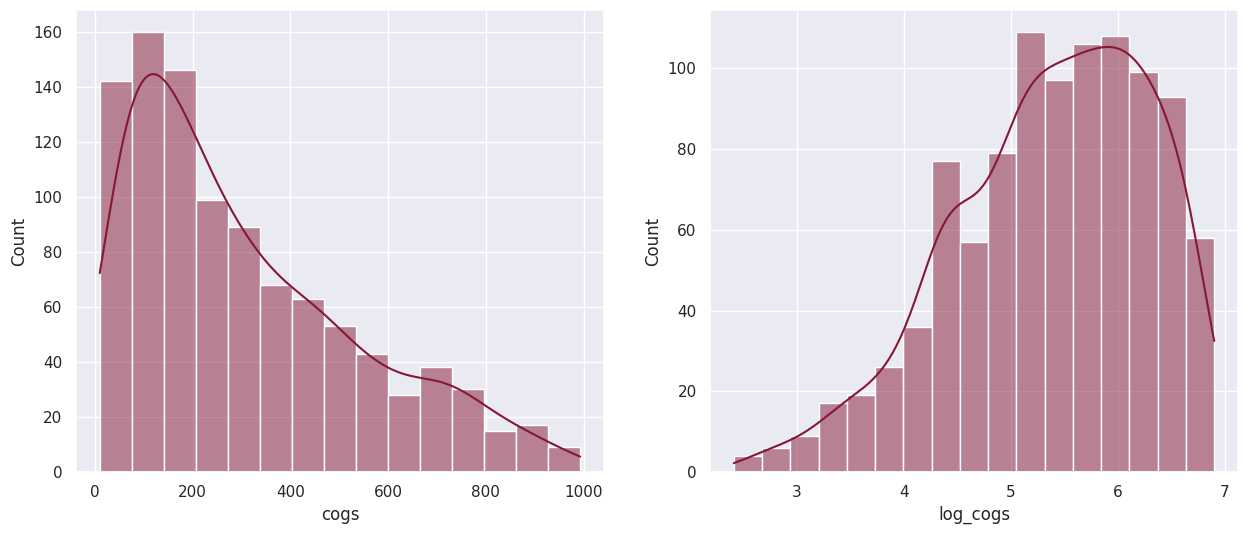

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

sns.histplot(df['cogs'], ax=ax1, kde=True)
sns.histplot(df['log_cogs'], ax=ax2, kde=True);

As we can see, the log transformation made the distribution of Cost of Goods Sold (cogs) more normally distributed (or less right-skewed). This will benefit models like linear regression as their weights/coefficients won't be strongly influenced by outliers that caused the initial skewness.

**Numeric Scaling**

We can see the range of **gross** **income** and **Rating** currently in our dataset.

Gross income range: 0.5085 to 49.65
Rating range: 4.0 to 10.0


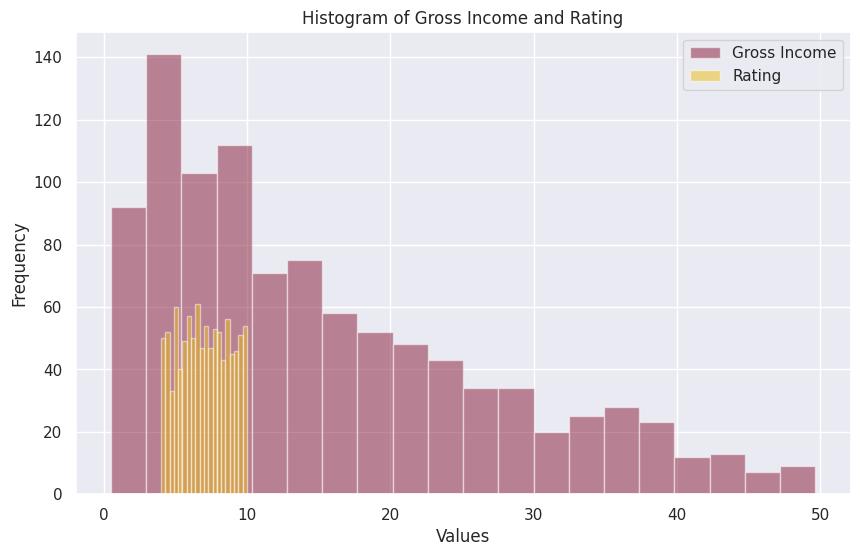

In [17]:
gincome = df["gross income"]
rating = df["Rating"]

print(f'Gross income range: {gincome.min()} to {gincome.max()}')
print(f'Rating range: {rating.min()} to {rating.max()}')

def plot_hist(data1, data2):
    plt.figure(figsize=(10, 6))
    plt.hist(data1, bins=20, alpha=0.5, label='Gross Income')
    plt.hist(data2, bins=20, alpha=0.5, label='Rating')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of Gross Income and Rating')
    plt.legend()
    plt.show()

plot_hist(gincome, rating)

We can see the difference in scale after applying normalization below.

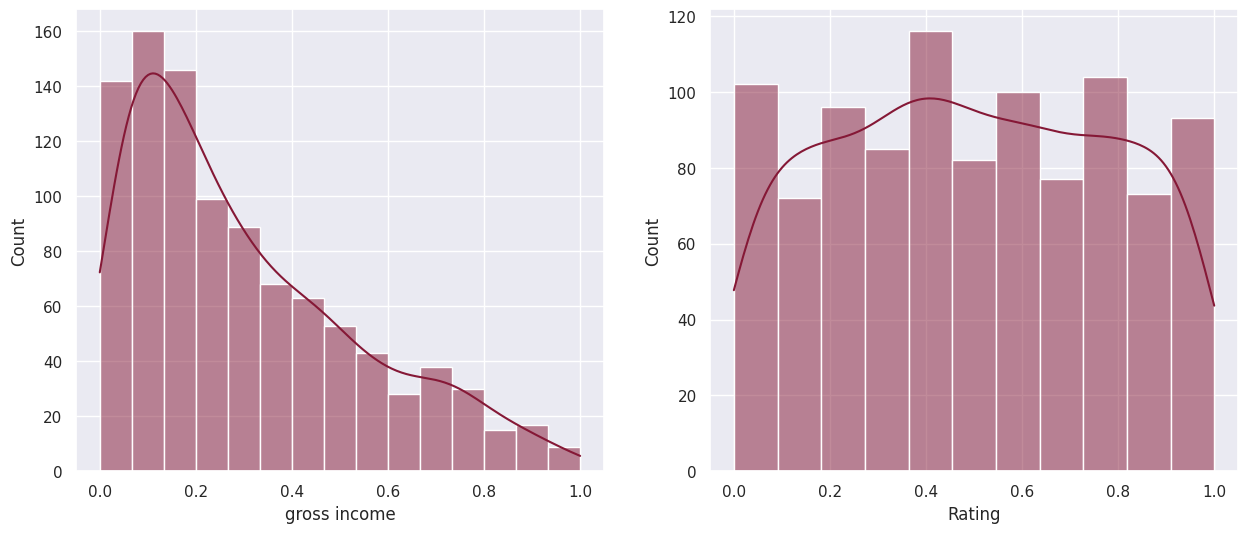

In [ ]:
df[["gross income", "Rating"]] = MinMaxScaler().fit_transform(df[["gross income", "Rating"]])

plot_hist(df['gross income'], df['Rating'])

Notice the graphs look the same but the scaling on the x-axis is between 0 and 1 now.

**One-hot encoding**

The below code shows how we can one-hot-encode two categorical columns - Gender and Payment.

In [ ]:
pd.get_dummies(df[['Gender','Payment']]).head()

,Gender_Female,Gender_Male,Payment_Cash,Payment_Credit card,Payment_Ewallet
0,1,0,0,0,1
1,1,0,1,0,0
2,0,1,0,1,0
3,0,1,0,0,1
4,0,1,0,0,1


But there are problems with this approach. If we have a column with 1000 categories, one-hot-encoding that one column will create 1000 new columns! That's a lot! You're feeding the model way too much information and it naturally is much harder to find patterns. When we have too much dimensionality, our model will take much longer to train and find the optimal predictor weights.

**Target encoding**

To resolve this, we can use target encoding



 we use target encoding in our supermarket dataset. For the example below, we use Product line as the categorical column that is target encoded, and Rating is the target variable, which is a continuous variable.

In [ ]:
means = df.groupby('Product line')['Rating'].mean()

df['Product line target encoded'] = df['Product line'].map(means)
df[['Product line','Product line target encoded','Rating']]

,Product line,Product line target encoded,Rating
0,Health and beauty,0.500548,0.850000
1,Electronic accessories,0.487451,0.933333
2,Home and lifestyle,0.472917,0.566667
3,Health and beauty,0.500548,0.733333
4,Sports and travel,0.486044,0.216667
...,...,...,...
995,Health and beauty,0.500548,0.366667
996,Home and lifestyle,0.472917,0.066667
997,Food and beverages,0.518870,0.616667
998,Home and lifestyle,0.472917,0.016667


**Missing Value Handling**

visualize the missing values using Seaborn.

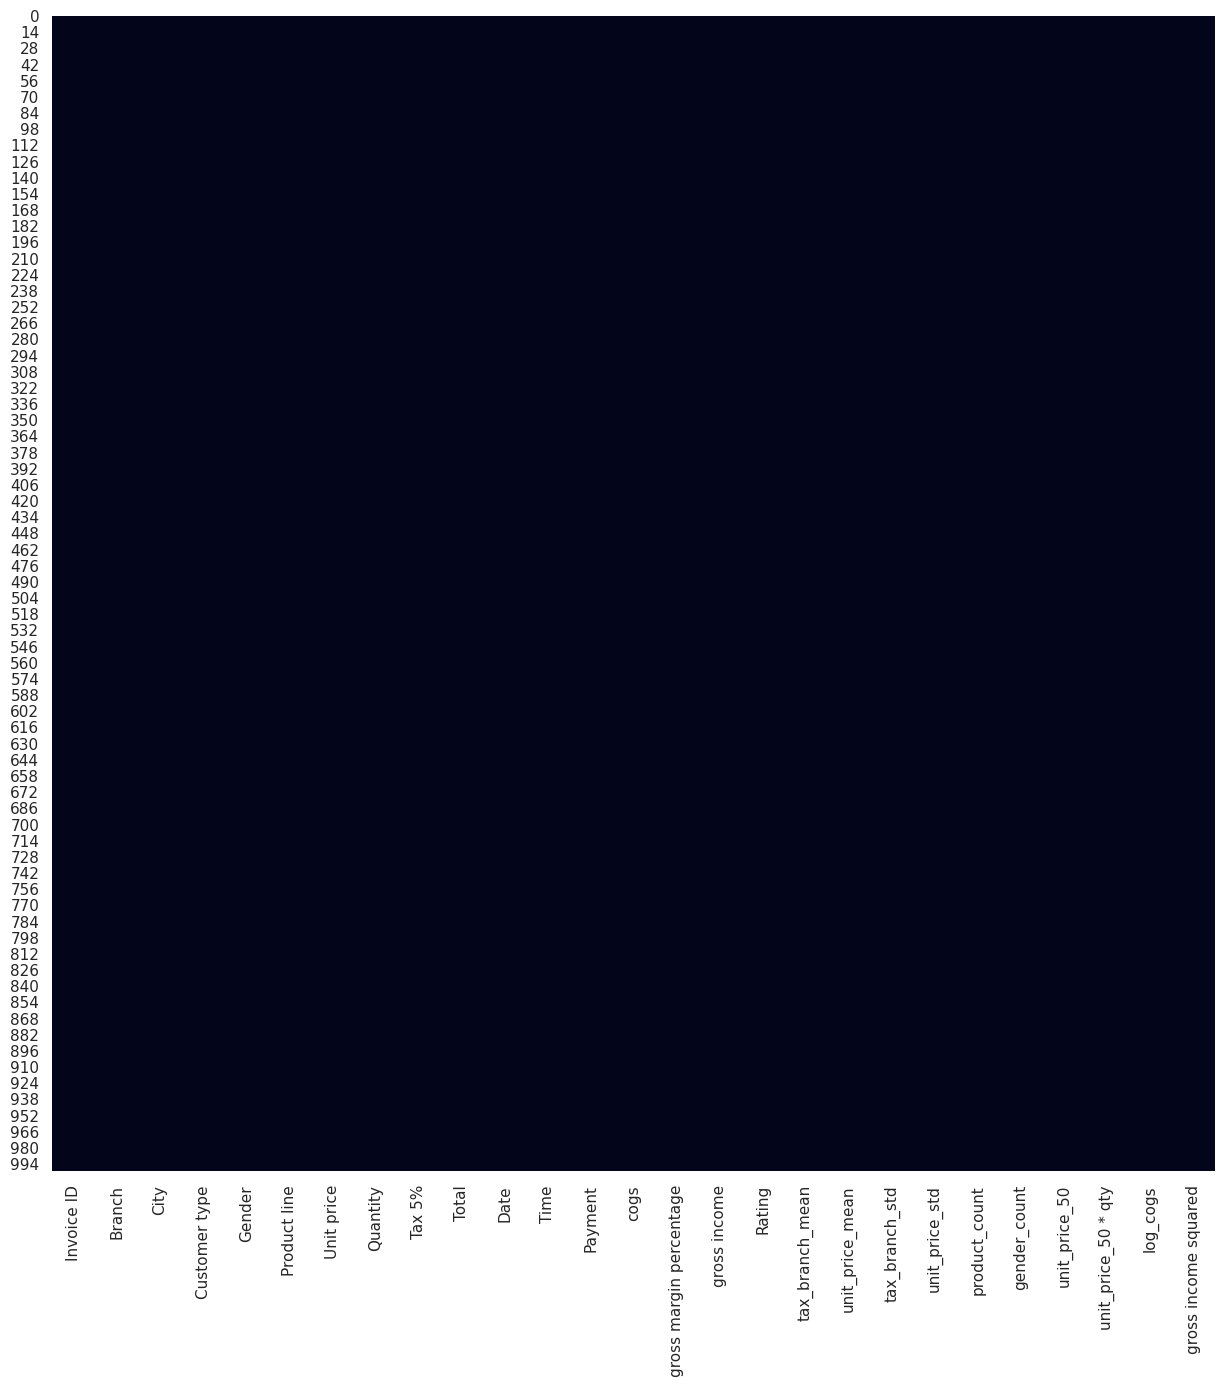

In [18]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.isnull(), cbar=False);

We see there are missing values in a few columns - Customer type, a categorical column, having the most missing values. Usually, columns with too many missing values don't provide enough signal for prediction - so some practitioners decide to remove those columns by setting a threshold for "missingness". In the below code chunk we set the threshold to be 70% and remove columns and rows that meet these conditions.(not prefer)

In [ ]:
threshold = 0.7

# Dropping columns with missing value rate higher than threshold
df = df[df.columns[df.isnull().mean() < threshold]]

# Dropping rows with missing value rate higher than threshold
df = df.loc[df.isnull().mean(axis=1) < threshold]

Alternatively (preferably), we can impute missing values with a single value such as the mean or median of the column. For categorical columns, we could impute missing values with the mode, or most frequent category in the column.

In [ ]:
# Filling missing values with medians of the columns
df = df.fillna(df.median())

# Fill remaining columns - categorical columns - with mode
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))

<ipython-input-29-f83ae3f3208f>:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df.fillna(df.median())


Now we see no more missing values in the dataset!

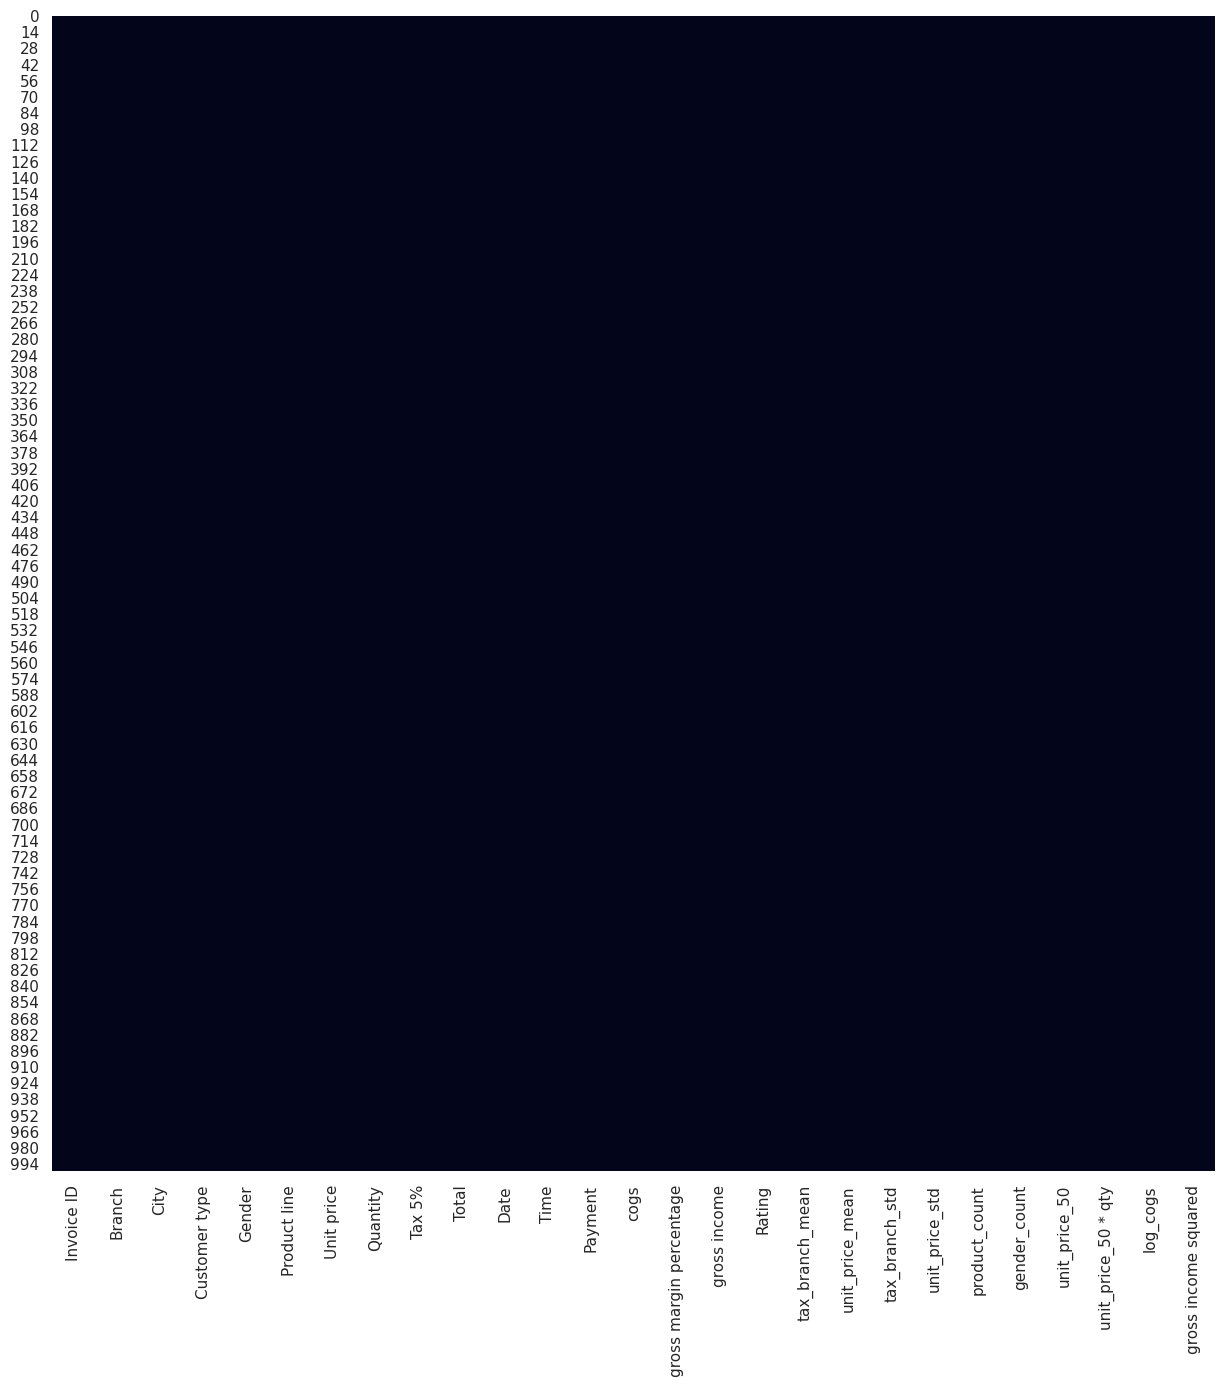

In [19]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.isnull(), cbar=False);

**Date-Time Decomposition**

Date-time decomposition is quite simply breaking down a date variable into its constituents. We do this as the model needs to works with numeric variables.



In [ ]:
# Convert to datetime object
df['Date'] = pd.to_datetime(df['Date'])
df[['Date']].head()

,Date
0,2019-01-05
1,2019-03-08
2,2019-03-03
3,2019-01-27
4,2019-02-08


In [ ]:
# Decomposition
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df[['Year','Month','Day']].head()

,Year,Month,Day
0,2019,1,5
1,2019,3,8
2,2019,3,3
3,2019,1,27
4,2019,2,8


What we've just done is separate out the date column which was in the format "year-month-day" into individual columns, namely year, month, and day. This is information that the model can now use to make predictions, as the new columns are numeric.